## Fourier Transforms for Signal Analysis 

The fourier transform is a powerful tool that can break down a time-series signal into the frequency domain allowing for insights into periodic influences that create the original signal. 

When dealing with discrete rather than continuous values, we can use the discrete Fourier transform given by:

$$ S[k] = \sum_N s_N[n]\cdot e^{-2 i\pi \frac{k}{N} n}, $$ 

this is implimented by the scipy.fftpack package using a fast fourier transform algorithm. 

To see how it can be used I will apply it first to simulated, then two real world data sets: 

## Creating a simulated signal:

In [1]:
# create a data set that has random frequency components
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from scipy.fftpack import rfft 
from scipy.fftpack import fft
from scipy.fftpack import fftshift

# cell magick to show plots within the cell
%matplotlib inline


/Users/holmium4/.virtualenvs/datascience/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Number of sample points
N = 600

# sampling time 
T = 0.00125

x = np.linspace(0.0, N*T, N)

# Create signal as combination of Sin functions 
y = (
    1*np.sin(60*2.0*np.pi*x) 
    + 0.2*np.sin(33.0 * 2.0*np.pi*x) 
    + 0.75*np.sin(80.0* 2.0*np.pi*x) 
    + 0.9*np.sin(200.0* 2.0*np.pi*x)
    )


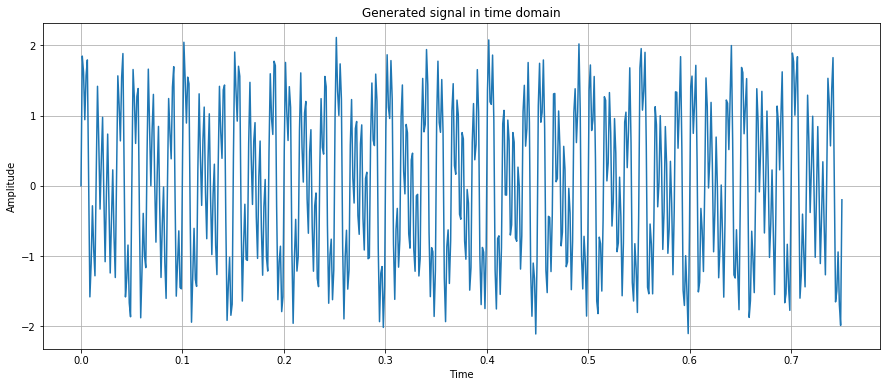

In [3]:
# The signal looks like this:
plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(x,y)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title('Generated signal in time domain')
plt.show()

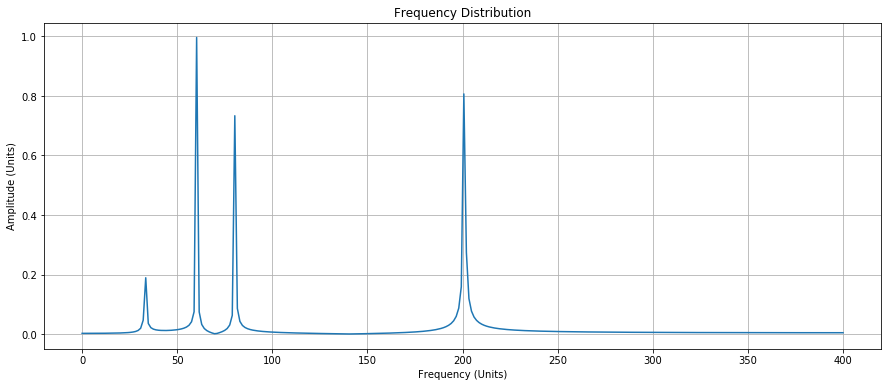

In [4]:
# Take the Fast-Fourier-Transfrom of the signal

yf = fft(y)
xf = np.linspace(0.0, 1.0/(2*T), N//2)

freq_values = 2/N*np.abs(yf[0:N//2])

plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(xf, freq_values)
plt.xlabel('Frequency (Units)')
plt.ylabel('Amplitude (Units)')
plt.title('Frequency Distribution')
plt.show()

#### From this we can see peaks at the frequences we built our signal from: 33, 60, 80, 200 

## Applying to Real World Data:

the first data set can be found here:

https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

and is the daily minimum temperatures in Melbourne Australia, from 1981-1990

In [5]:
import pandas as pd

# Daily minimum temperatures in Melbourne, Australia, 1981-1990
data = pd.read_csv("./min_temp.csv")

In [6]:
# extract respns variable
temps = data['min_temp']

# want to normalize by removing the mean 
mu = np.mean(temps)
temps = temps - mu

N = len(data)
s_freq = 1 # 1 sample per 1 day


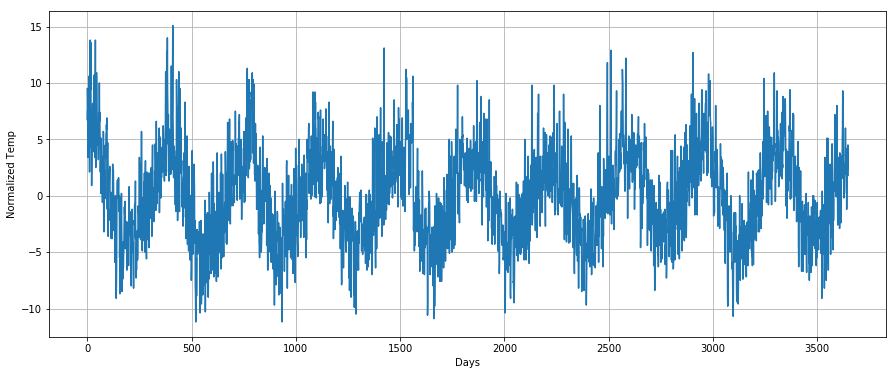

In [17]:
# Plot the signal 

# due to shannon-nyquist theorem maximum freq is half of our sample freq
x = np.linspace(0, N, N, endpoint=True)

plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(x, temps)
plt.xlabel('Days')
plt.ylabel('Normalized Temp')
plt.show()


#### we can clearly see there is some yearly periodic cycle, as is expected

## Apply Hanning Window 

Because the fourier transform was made for a periodic signals we must convolve our signal with a window function in order to avoid signal leakage

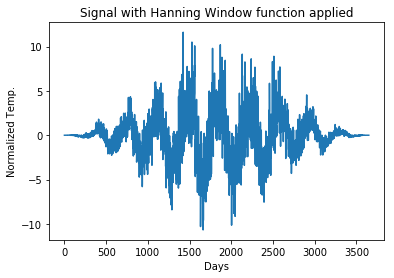

In [19]:
# chose a hanning window
hann = np.hanning(len(x))

temps_h = hann*temps
plt.plot(x,temps_h)
plt.xlabel('Days')
plt.ylabel('Normalized Temp.')
plt.title('Signal with Hanning Window function applied')

## Applying the FFT to Windowed Signal:

/Users/holmium4/.virtualenvs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


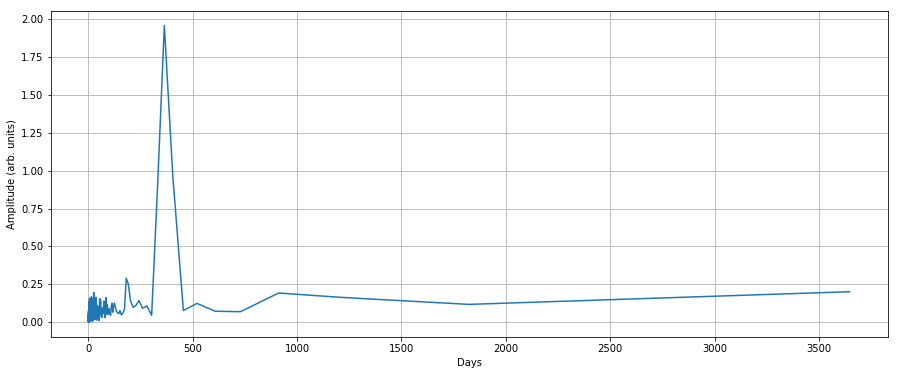

In [22]:
# fourier Transform on the temperature data: 
tempsf = fft(temps_h)
x_f = np.linspace(0.0, 0.5, N//2)

# plot x values in periods not frequencies 
x_p = 1/x_f
freq_values = 2/N * np.abs(tempsf[0:N//2])

# plot
plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(x_p, freq_values)
plt.xlabel('Days')
plt.ylabel ('Amplitude (arb. units)')
plt.show()


#### we can see there is the main peak around the year mark, but we will use a peak finding algorithm to determine the greatest peaks


## Peak Finding:

In [23]:
# Note - I did not write this function.
# It is a common Matlab function ported to Python
# Can be found here: http://billauer.co.il/peakdet.html

import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    
    """
    Function to detect peaks 
    Converted from MATLAB script 

    """

    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

In [24]:
# Apply the function to our data

max, min = peakdet(freq_values, 0.17)

# determining indicies
x_inds = [int(elem[0]) for elem in max]
x_peaks = [x_p[x] for x in x_inds]
y_peaks = [elem[1] for elem in max]


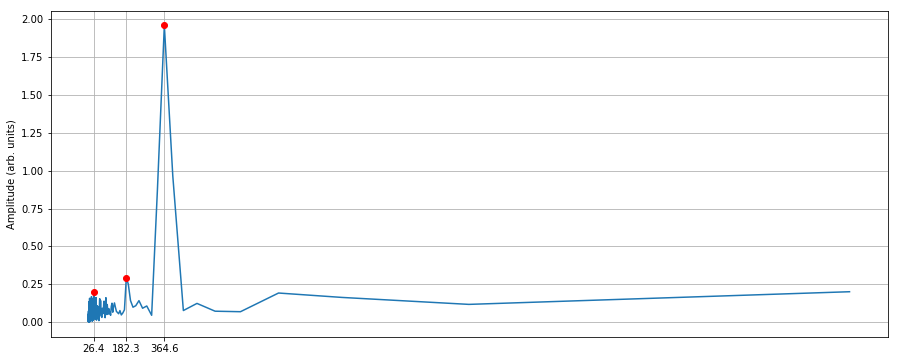

peaks found at [364.60000000000002, 182.30000000000001, 26.420289855072461]


In [26]:

# plot
plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(x_p, freq_values)
plt.plot(x_peaks, y_peaks, 'ro')
plt.ylabel('Amplitude (arb. units)')
plt.xticks(x_peaks)
plt.show()

print('peaks found at {}'.format(x_peaks))


#### conclusions: 
* From this we find that by far the largest peak corresponds to the yearly cycle 364.6 ~ 365 days/year
* There is also a sizable peak for the summer / winter cycle which corresponds to 365/2 = 182.5 
* Finally and perhaps most interestingly, there is some signal at 26.4 days which is very close to the lunar orbit of 27.3 days

# Sunspot Data

Performing the same analysis steps on another data set of the monthly number of sunspots from 1749-1983


Data can be found here:


https://datamarket.com/data/set/22ti/zuerich-monthly-sunspot-numbers-1749-1983#!ds=22ti&display=line

In [27]:
# Zuerich monthly sunspot numbers 1749-1983
sun_data = pd.read_csv("./sunspots.csv")
sunspots = sun_data['Sunspots'].values


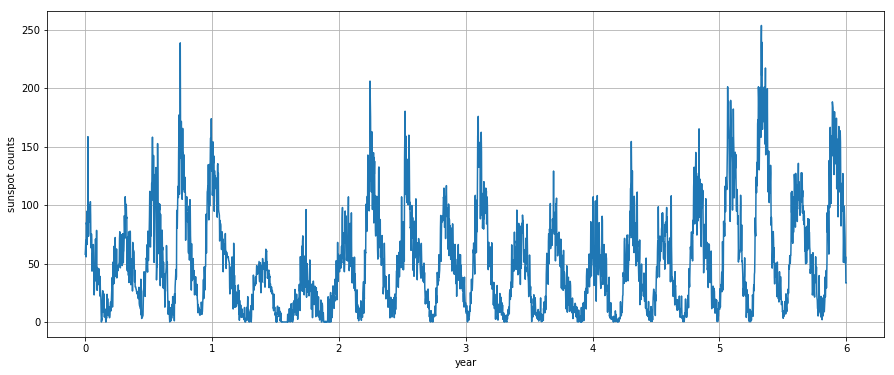

In [29]:
s_N = len(sunspots)
s_freq = 12 # / year - Data set sampled once per month  
s_x = np.linspace(0, s_freq/2, s_N, endpoint=True)


plt.figure(figsize=(15,6))
plt.grid(True)
plt.xlabel('year')
plt.ylabel('sunspot counts')
plt.plot(s_x, sunspots, label="Sunspots")
plt.show()


In [30]:
# normalize the data around 0 
mu = np.mean(sunspots) 
sunspots = sunspots - mu 

# Apply the Hanning window:
hann_s = np.hanning(s_N)
sunspots_h = hann_s*sunspots


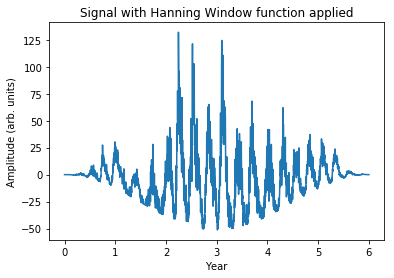

In [32]:

plt.plot(s_x, sunspots_h)
plt.xlabel('Year')
plt.ylabel('Amplitude (arb. units)')
plt.title('Signal with Hanning Window function applied')

In [33]:
# Apply the FFT:

# due to shannon-nyquist theorem maximum freq is half of our sample freq
x_f = np.linspace(0, s_freq/2, s_N/2, endpoint=True)

sunspotsf = fft(sunspots_h)
x_p = 1/x_f

freq_values = 2/s_N * np.abs(sunspotsf[0:s_N//2])

/Users/holmium4/.virtualenvs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/Users/holmium4/.virtualenvs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


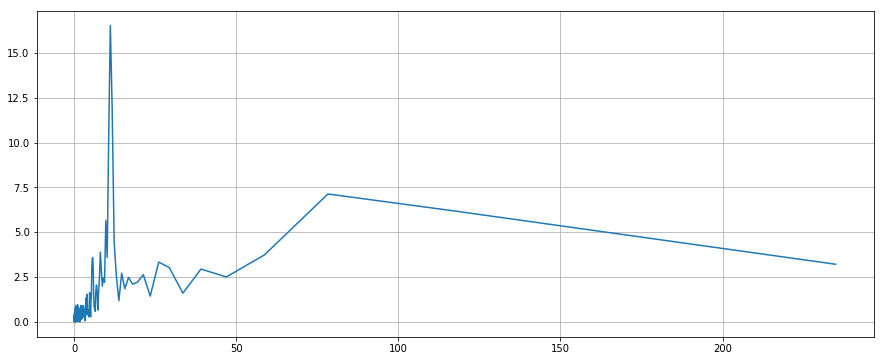

In [34]:
plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(x_p, freq_values)
plt.show()

In [35]:
#Find the peaks as we did before

max, min = peakdet(freq_values, 1.5)

x_inds = [int(elem[0]) for elem in max]
x_peaks = [x_p[x] for x in x_inds]
y_peaks = [elem[1] for elem in max]


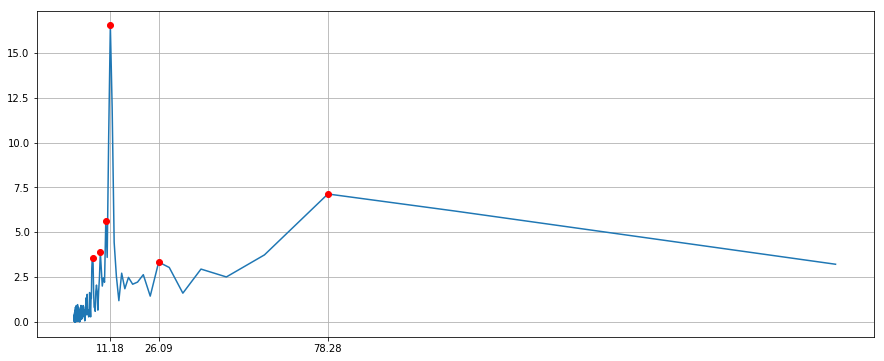

In [36]:
# plot
plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(x_p, freq_values)
plt.plot(x_peaks, y_peaks, 'ro')
plt.xticks(sorted(x_peaks[1:4]))
plt.show()

#### Conclusions 
According to https://en.wikipedia.org/wiki/Solar_cycle
* The sun as an activity cycle of ~ 11 years which can be seen in the prominent peak. 
* there is also a wider (70–100 year) cycle called the Gleissberg cycle which our spectrum shows
* To what physical phenomena the other prominant peaks correspond to is uncertain. 